<a href="https://colab.research.google.com/github/norannali/unsupervised-customer-segmentation/blob/main/Customer_Segmentation_Via_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Libraries**

In [ ]:
# Core libraries
import warnings
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN,OPTICS

# Metrics & dimensionality reduction
from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.decomposition import PCA

# Hierarchical clustering tools
from scipy.cluster.hierarchy import dendrogram, linkage
# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('/content/bank-full.csv',delimiter=";")

# **2.Data Overview**

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [ ]:
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Key Insight:**  
Several features (**balance, duration, campaign, pdays, previous**) are **highly skewed**.  
For clustering or modeling, **scaling (StandardScaler / MinMaxScaler)** and possibly **log-transformation** would improve performance.

In [ ]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


## Key Insights

-  **Dataset Quality**  
   - No missing values.  
   - No duplicate records.  
   - Data is already clean and ready for preprocessing.  

-  **Numeric Variables**  
   - Several features are **skewed** (e.g., balance, duration, campaign, pdays, previous).  
   - **Scaling/Normalization** (e.g., StandardScaler, MinMaxScaler, or log-transform) is critical, especially before clustering or distance-based models.  

-  **Categorical Variables**  
   - Require **encoding** (One-Hot Encoding or Label Encoding) for use in machine learning models.  
   - Many categorical features (job, marital, education, etc.) with varying frequencies → encoding must preserve important patterns.  


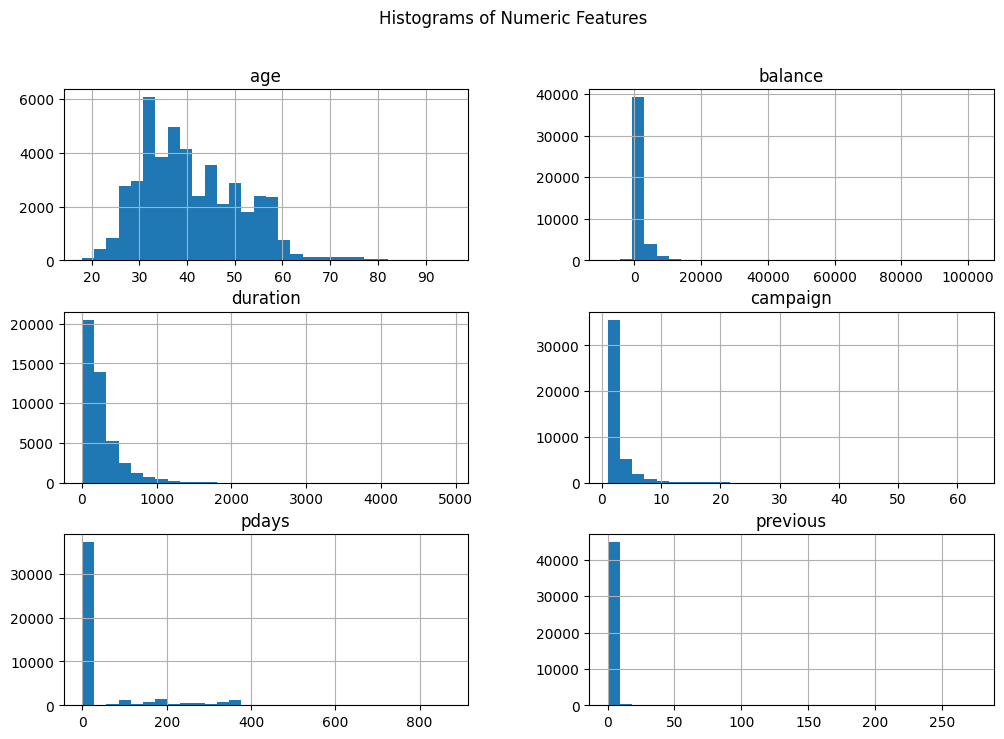

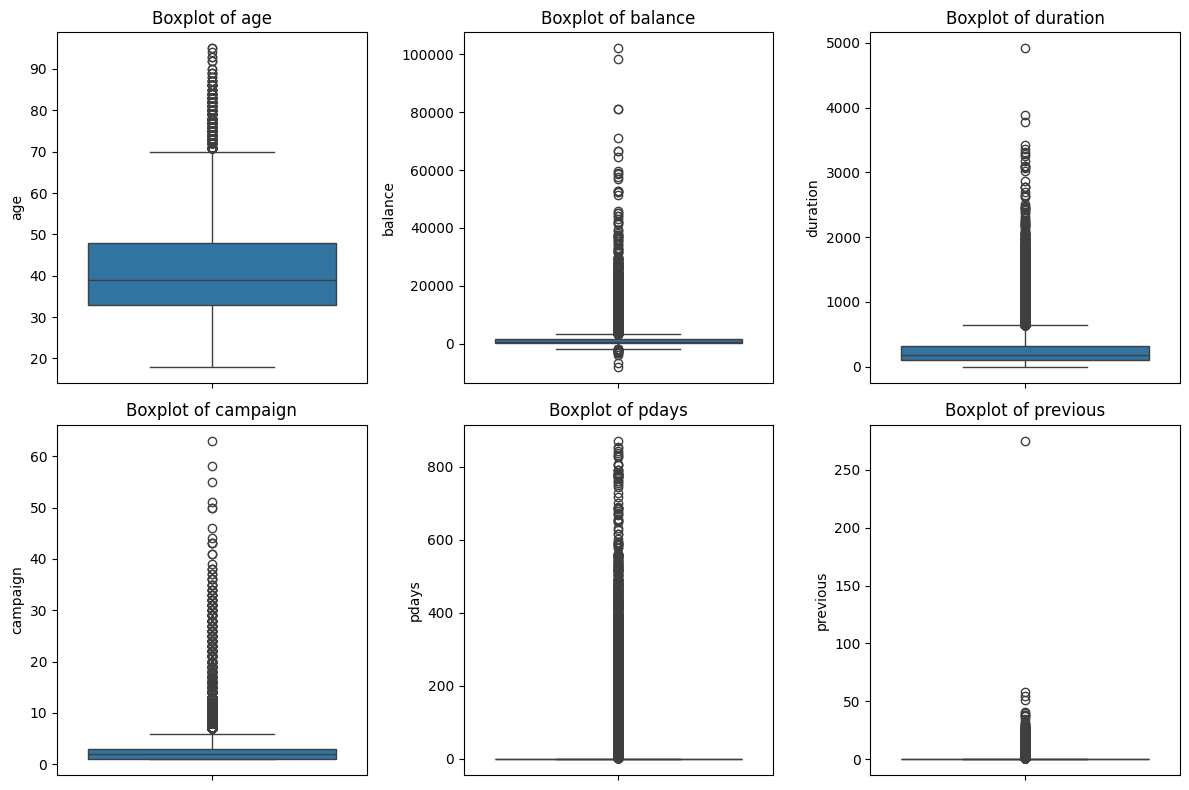

In [ ]:
numeric_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]

# Histograms
df[numeric_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Histograms of Numeric Features")
plt.show()

# Boxplots
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

- **Balance, Duration, Campaign, Pdays, and Previous** require **scaling** (StandardScaler or MinMaxScaler).  
  - Applying a **Log-transform** or **RobustScaler** can help reduce the strong influence of extreme outliers.  

- **Age** is relatively stable compared to the other variables and does not require major transformation.  

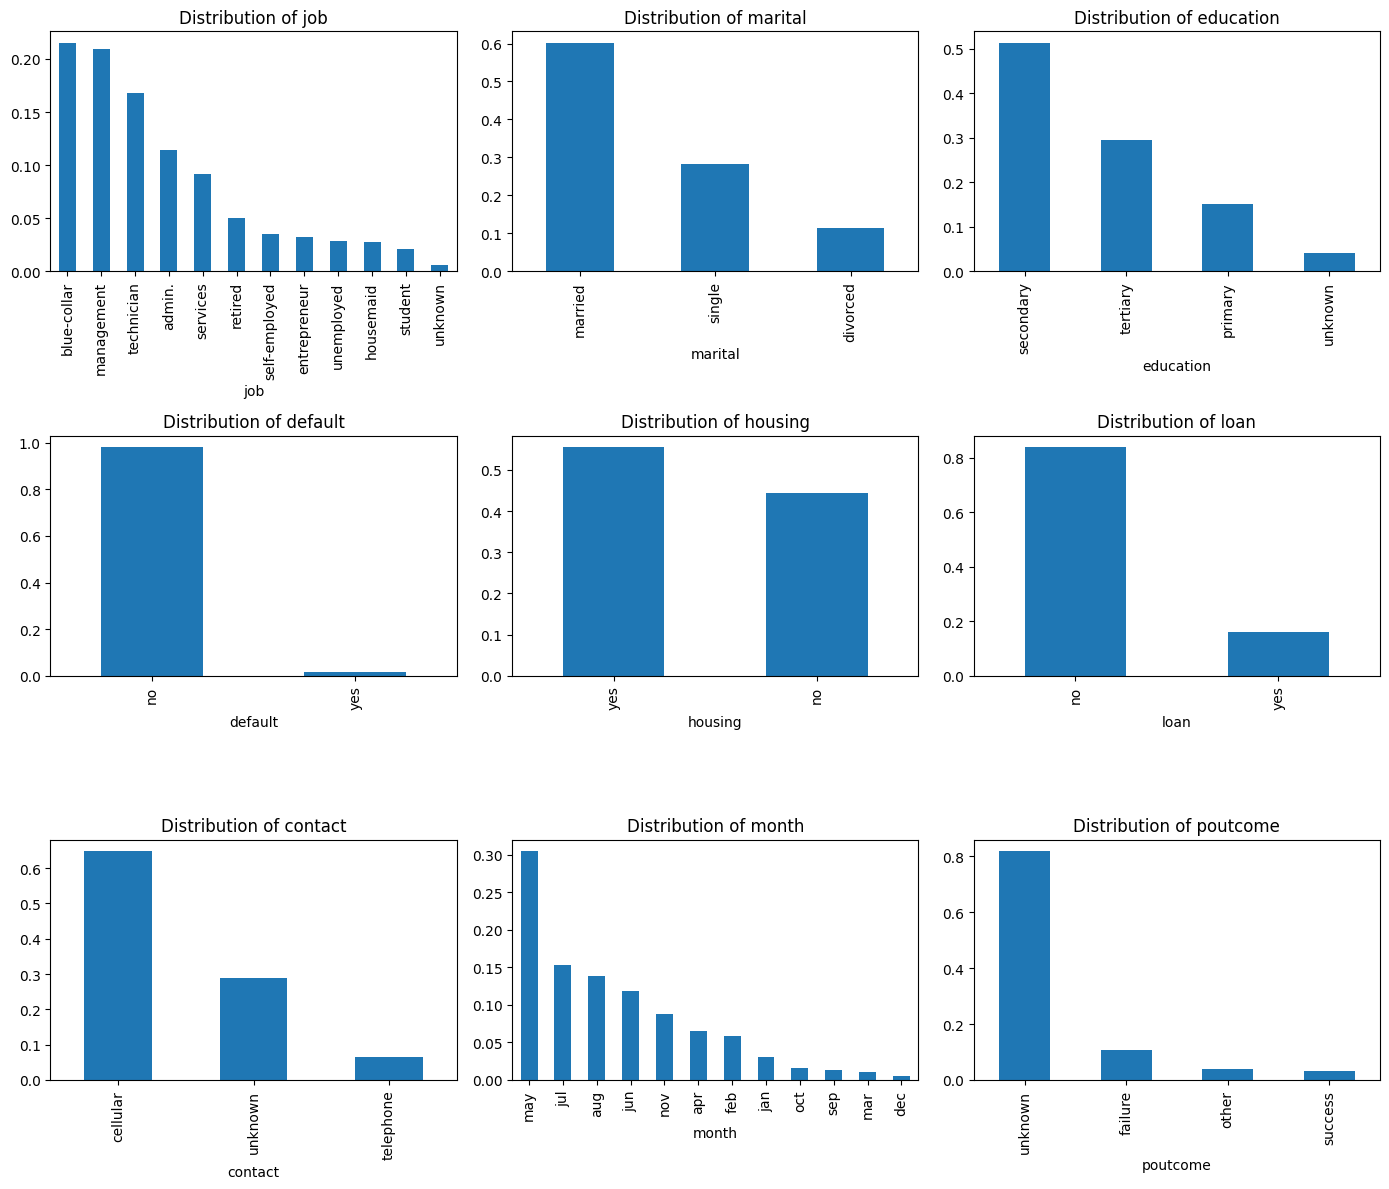

In [ ]:
categorical_cols = ["job", "marital", "education", "default",
                    "housing", "loan", "contact", "month", "poutcome"]

plt.figure(figsize=(14, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    df[col].value_counts(normalize=True).plot(kind="bar")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# **3.Data Preprocessing**

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
for col in categorical_cols:
    print(f'{col}:')
    print(df[col].unique())
    print('\n')

job:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


marital:
['married' 'single' 'divorced']


education:
['tertiary' 'secondary' 'unknown' 'primary']


default:
['no' 'yes']


housing:
['yes' 'no']


loan:
['no' 'yes']


contact:
['unknown' 'cellular' 'telephone']


month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


poutcome:
['unknown' 'failure' 'other' 'success']




## **1.Encoding Categorical Variables**

In [ ]:
df_encoded = df.copy()

# 1 Label Encoding for binary columns
label_cols = ["default", "housing", "loan"]
le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# 2 Ordinal Encoding for education column
edu_mapping = {"primary": 0, "secondary": 1, "tertiary": 2, "unknown": -1}
df_encoded["education"] = df_encoded["education"].map(edu_mapping)

# 3 One-Hot Encoding for the remaining categorical columns
onehot_cols = ["job", "marital", "contact", "month", "poutcome"]

# apply OneHotEncoding
df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)

In [ ]:
df_encoded.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2,0,2143,1,0,5,261,1,-1,...,False,False,False,True,False,False,False,False,False,True
1,44,1,0,29,1,0,5,151,1,-1,...,False,False,False,True,False,False,False,False,False,True
2,33,1,0,2,1,1,5,76,1,-1,...,False,False,False,True,False,False,False,False,False,True
3,47,-1,0,1506,1,0,5,92,1,-1,...,False,False,False,True,False,False,False,False,False,True
4,33,-1,0,1,0,0,5,198,1,-1,...,False,False,False,True,False,False,False,False,False,True


## **2.scale numeric features**



> Clustering algorithms like K-Means, DBSCAN, Hierarchical Clustering are distance-based → features must be on the same scale.



In [ ]:
# 4. Normalize/scale numeric features
scaler = StandardScaler()
num_cols = ["age", "balance", "duration", "campaign", "pdays"]
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

In [ ]:
df_encoded.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,2,0,0.256419,1,0,5,0.011016,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
1,0.288529,1,0,-0.437895,1,0,5,-0.416127,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
2,-0.747384,1,0,-0.446762,1,1,5,-0.707361,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
3,0.571051,-1,0,0.047205,1,0,5,-0.645231,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
4,-0.747384,-1,0,-0.447091,0,0,5,-0.233620,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True


# **4.Feature Selection**



We will focus on the most relevant features for clustering:  

- **Age** → demographic segmentation.  
- **Job** → occupation type, proxy for income/social class.  
- **Marital status** → family situation, may influence financial behavior.  
- **Balance** → financial strength and account activity.  
- **Duration of last contact** → key driver of campaign outcome.  
- **Number of contacts (Campaign + Previous)** → frequency of bank interactions.  
- **Days since last contact (Pdays)** → recency of customer engagement.  


In [ ]:
df_encoded.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [ ]:
features = [
    "age", "education", "default", "balance",
    "housing", "loan", "day", "duration",
    "campaign", "pdays"
]

# One-Hot encoded columns
onehot_features = [col for col in df_encoded.columns if col.startswith(("job_", "marital_", "contact_", "month_", "poutcome_"))]

selected_features = features + onehot_features

X = df_encoded[selected_features]

In [ ]:
X.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,2,0,0.256419,1,0,5,0.011016,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
1,0.288529,1,0,-0.437895,1,0,5,-0.416127,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
2,-0.747384,1,0,-0.446762,1,1,5,-0.707361,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
3,0.571051,-1,0,0.047205,1,0,5,-0.645231,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True
4,-0.747384,-1,0,-0.447091,0,0,5,-0.233620,-0.569351,-0.411453,...,False,False,False,True,False,False,False,False,False,True


# **5. K-Means (Clustering)**

In [ ]:
# Test multiple k values for silhouette score
silhouette_scores = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.3f}")

K=2: Silhouette Score = 0.505
K=3: Silhouette Score = 0.458
K=4: Silhouette Score = 0.381
K=5: Silhouette Score = 0.311
K=6: Silhouette Score = 0.311
K=7: Silhouette Score = 0.256


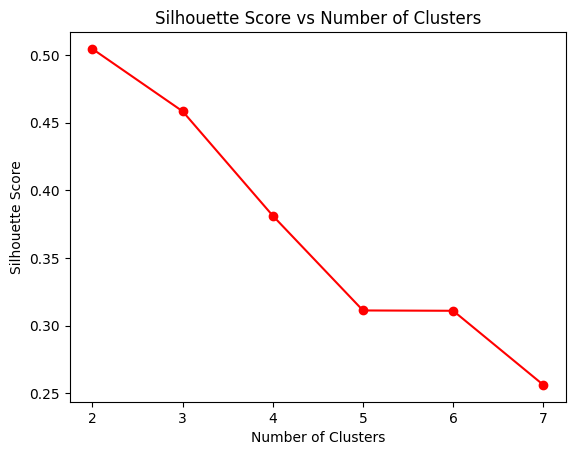

In [ ]:
# Plot silhouette scores
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

## *1.Elbow Method*

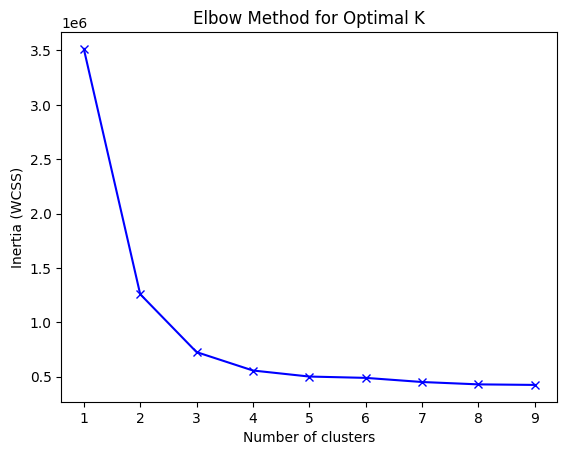

In [ ]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.show()

## *2.K-Means Clustering*

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

## *3.Silhouette Score*

In [ ]:
score = silhouette_score(X, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.50451264604118


## *4.PCA Visualization*

In [ ]:
df_clustered = X.copy()
df_clustered["Cluster"] = kmeans.labels_

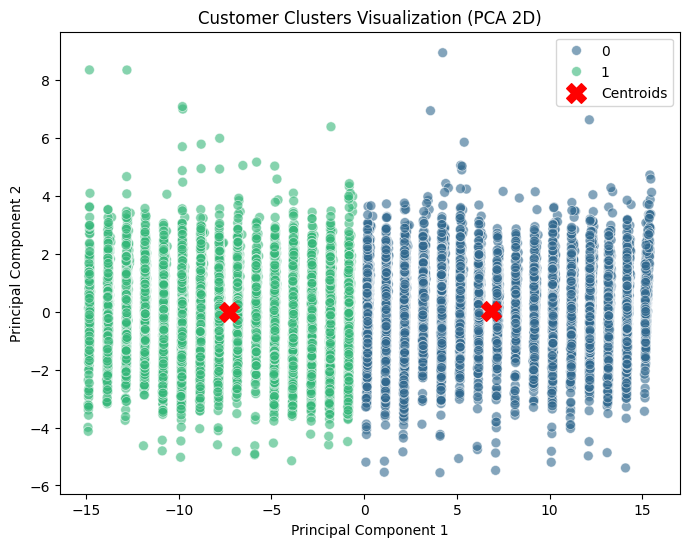

In [ ]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
# cluster labels
df_vis = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_vis['Cluster'] = kmeans.labels_
# Get centroids in PCA space
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=df_vis, palette="viridis", s=50, alpha=0.6)
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=200, label='Centroids')
plt.title("Customer Clusters Visualization (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## *5.Cluster Profiling*

In [ ]:
df_profile = df.copy()
df_profile["Cluster"] = kmeans.labels_

In [ ]:
# Numeric summary
df_profile.groupby("Cluster")[["age", "balance", "duration", "campaign", "pdays"]].mean()

,age,balance,duration,campaign,pdays
Cluster,,,,,
0,40.796888,1432.632714,252.132414,3.126440,29.973999
1,41.083945,1287.662763,264.557900,2.379346,51.039010


In [ ]:
# Categorical distribution example
df_profile.groupby("Cluster")["job"].value_counts(normalize=True)

Cluster  job          
0        management       0.221678
         blue-collar      0.202037
         technician       0.178958
         admin.           0.110968
         services         0.089608
         retired          0.045728
         self-employed    0.037047
         entrepreneur     0.034382
         housemaid        0.028064
         unemployed       0.027720
         student          0.017922
         unknown          0.005888
1        blue-collar      0.229276
         management       0.195962
         technician       0.156451
         admin.           0.117988
         services         0.094290
         retired          0.054687
         self-employed    0.032676
         entrepreneur     0.031308
         unemployed       0.029987
         housemaid        0.026751
         student          0.023743
         unknown          0.006881
Name: proportion, dtype: float64

### **5.1. Boxplots for numeric features**

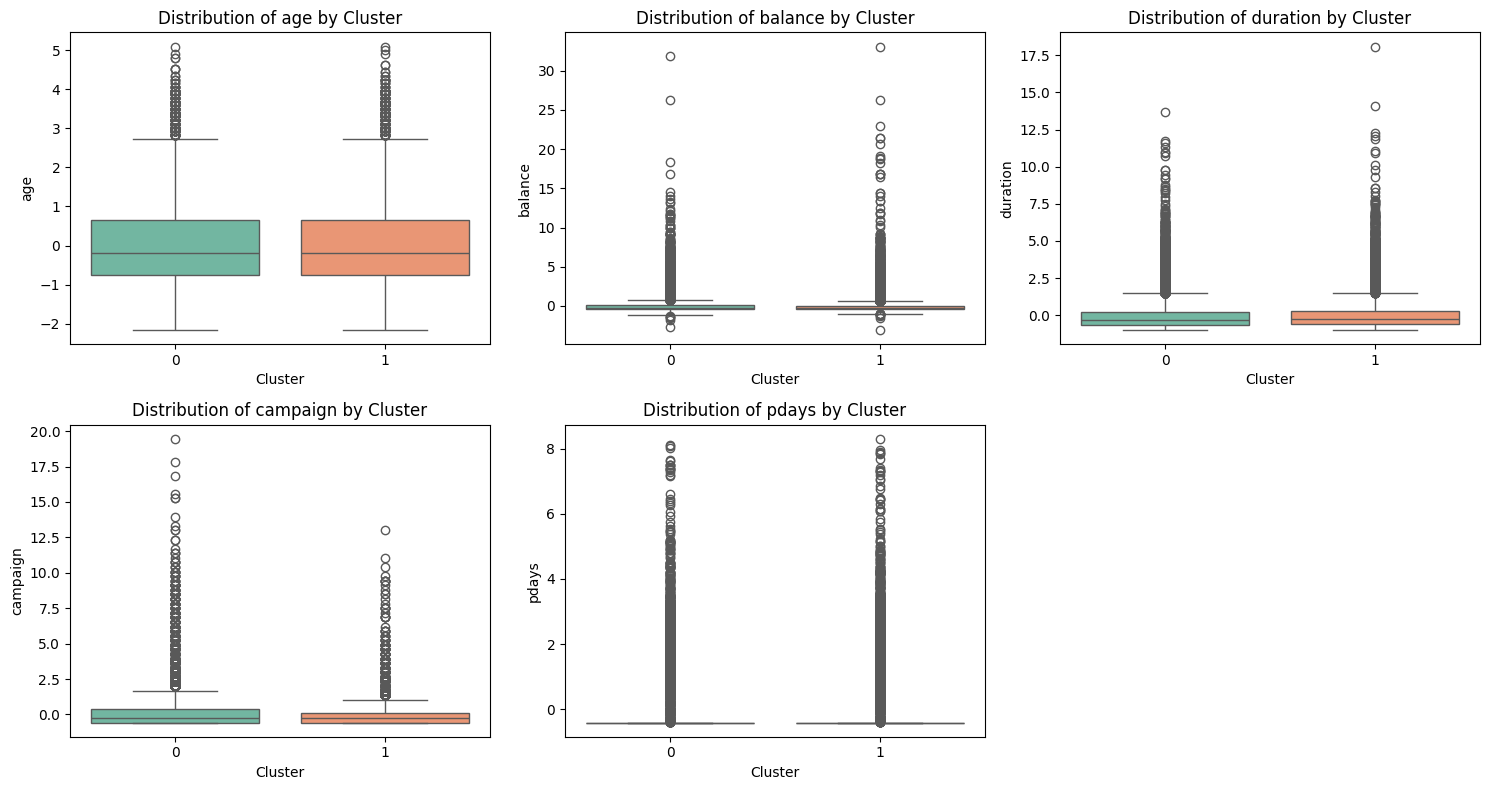

In [ ]:
numeric_features = ["age", "balance", "duration", "campaign", "pdays"]

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="Cluster", y=col, data=df_clustered, palette="Set2")
    plt.title(f"Distribution of {col} by Cluster")
plt.tight_layout()
plt.show()

###**5.2. Radar Chart (Cluster Profiles)**

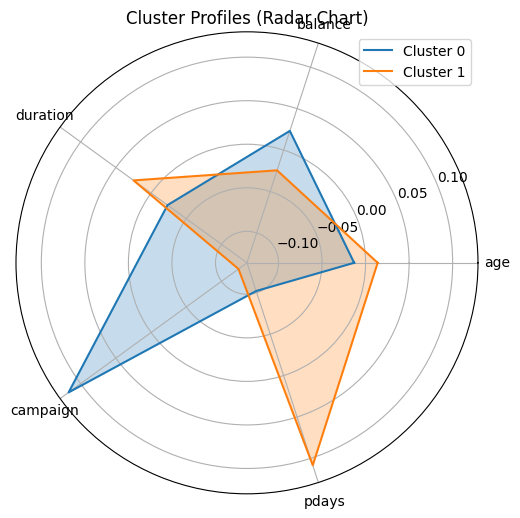

In [ ]:
# Compute mean values
cluster_means = df_clustered.groupby("Cluster")[numeric_features].mean()

# Radar setup
labels = numeric_features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # repeat first value
    ax.plot(angles, values, label=f"Cluster {i}")
    ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Cluster Profiles (Radar Chart)")
plt.legend()
plt.show()

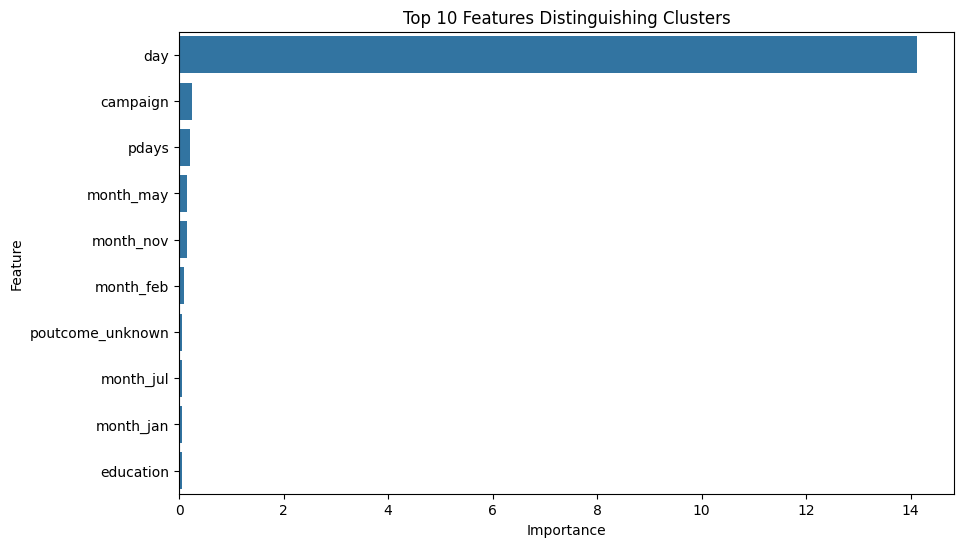

In [ ]:
# Feature importance in clustering
feature_importance = np.abs(kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1])
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Features Distinguishing Clusters')
plt.show()

###  Customer Segmentation Summary

##  Cluster 0 – *“Professionals with Higher Balance”*
-  Higher financial balance  
-  Require more follow-up calls to be convinced  
-  Jobs: Mainly **management (22%)**, **blue-collar (20%)**, plus many technicians  
-  Traits: Younger, financially stable, less responsive in conversations  
-  Interpretation: Financially stable professionals, but harder to convince. Need exclusive offers or premium products.  

---

##  Cluster 1 – *“Working-Class Responsive Clients”*
-  Lower balance compared to Cluster 0  
-  More responsive → fewer calls needed  
-  Jobs: Mostly **blue-collar (23%)** and **management (19%)**  
-  Traits: Older, longer call durations, more engaged in discussions  
-  Interpretation: Working-class clients, easier to convince, suitable for accessible financial products and loyalty programs.  

---

##  Quick Comparison

| Feature   | Cluster 0 (Blue)                | Cluster 1 (Red)               |
|-----------|---------------------------------|-------------------------------|
| Balance   | Higher                          | Lower                         |
| Calls     | More calls needed               | Fewer calls needed            |
| Jobs      | More in management/technicians  | More in blue-collar jobs      |
| Behavior  | Harder to convince              | More responsive               |


# **6.DBSCAN Clustering**

In [ ]:
# Test different eps values
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels_db = dbscan.fit_predict(X)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = list(labels_db).count(-1)
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")

eps=0.3: 11 clusters, 45145 noise points
eps=0.5: 172 clusters, 43793 noise points
eps=0.7: 415 clusters, 41167 noise points
eps=1.0: 783 clusters, 36929 noise points
eps=1.5: 57 clusters, 14268 noise points


In [ ]:
# Reduce dimensions
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

print(f"   Original dimensions: {X.shape[1]}")
print(f"   Reduced dimensions: {X_pca.shape[1]}")
print(f"   Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

   Original dimensions: 39
   Reduced dimensions: 10
   Explained variance ratio: 0.980


## DBSCAN ON PCA-REDUCED DATA

In [ ]:
pca_dbscan_results = []
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

for eps in eps_values:
    dbscan_pca = DBSCAN(eps=eps, min_samples=5)
    labels_pca = dbscan_pca.fit_predict(X_pca)

    n_clusters = len(set(labels_pca)) - (1 if -1 in labels_pca else 0)
    n_noise = list(labels_pca).count(-1)
    noise_ratio = n_noise / len(labels_pca) * 100

    pca_dbscan_results.append({
        'eps': eps,
        'clusters': n_clusters,
        'noise': n_noise,
        'noise_ratio': noise_ratio
    })

    print(f"   eps={eps:3.1f}: {n_clusters:2d} clusters, {n_noise:4d} noise points ({noise_ratio:5.1f}%)")

   eps=0.5: 540 clusters, 37072 noise points ( 82.0%)
   eps=1.0: 155 clusters, 11865 noise points ( 26.2%)
   eps=1.5: 15 clusters, 2555 noise points (  5.7%)
   eps=2.0:  3 clusters,  696 noise points (  1.5%)
   eps=2.5:  3 clusters,  229 noise points (  0.5%)
   eps=3.0:  2 clusters,  100 noise points (  0.2%)


In [ ]:
# Find the best parameters
best_pca_result = min(pca_dbscan_results,
                      key=lambda x: abs(x['clusters'] - 3) + x['noise_ratio']/100)  # Target ~3 clusters, minimize noise

print(f"RECOMMENDED PARAMETERS:")
print(f"   Best eps for PCA data: {best_pca_result['eps']}")
print(f"   Results: {best_pca_result['clusters']} clusters, {best_pca_result['noise_ratio']:.1f}% noise")

RECOMMENDED PARAMETERS:
   Best eps for PCA data: 2.5
   Results: 3 clusters, 0.5% noise


In [ ]:
print(f"TESTING DIFFERENT MIN_SAMPLES VALUES:")
min_samples_values = [3, 5, 10, 20, 50]
for min_samples in min_samples_values:
    dbscan_alt = DBSCAN(eps=best_pca_result['eps'], min_samples=min_samples)
    labels_alt = dbscan_alt.fit_predict(X_pca)

    n_clusters = len(set(labels_alt)) - (1 if -1 in labels_alt else 0)
    n_noise = list(labels_alt).count(-1)
    noise_ratio = n_noise / len(labels_alt) * 100

    print(f"   min_samples={min_samples:2d}: {n_clusters:2d} clusters, {noise_ratio:5.1f}% noise")

TESTING DIFFERENT MIN_SAMPLES VALUES:
   min_samples= 3:  9 clusters,   0.4% noise
   min_samples= 5:  3 clusters,   0.5% noise
   min_samples=10:  1 clusters,   0.8% noise
   min_samples=20:  1 clusters,   1.0% noise
   min_samples=50:  1 clusters,   1.5% noise


In [ ]:
db = DBSCAN(eps=2.5, min_samples=5)
clusters = db.fit_predict(X_pca)

In [ ]:
df_profile2 = df.copy()
df_profile2["cluster"] = clusters

In [ ]:
#X["cluster"] = clusters

In [ ]:
# Numeric features: mean & median per cluster
numeric_cols = ["age", "balance", "duration", "campaign", "pdays"]
summary_num = df_profile2.groupby("cluster")[numeric_cols].agg(["mean", "median"])

# Categorical features: distribution per cluster
categorical_cols = ["job", "marital", "education", "housing", "loan", "contact", "month", "poutcome"]
summary_cat = {}
for col in categorical_cols:
    summary_cat[col] = df_profile2.groupby("cluster")[col].value_counts(normalize=True).unstack(fill_value=0)

In [76]:
print(" Numeric Features Summary:")
summary_num

 Numeric Features Summary:


age              balance             duration         \
              mean median          mean   median        mean median   
cluster                                                               
-1       46.240175   45.0  16968.336245  11891.0  832.301310  339.0   
 0       40.908901   39.0   1278.890445    445.0  255.278145  180.0   
 1       33.250000   33.5    362.750000     55.0   26.500000   24.5   
 2       49.800000   51.0  37388.400000  36935.0   96.800000   63.0   

          campaign              pdays         
              mean median        mean median  
cluster                                       
-1        8.004367    2.0  135.890830   -1.0  
 0        2.734819    2.0   39.718809   -1.0  
 1       31.000000   31.5   -1.000000   -1.0  
 2        1.200000    1.0   -1.000000   -1.0

In [78]:
print("Categorical Features Distribution:")
for col, table in summary_cat.items():
    print(f"\nFeature: {col}")
    print(table)

Categorical Features Distribution:

Feature: job
job        admin.  blue-collar  entrepreneur  housemaid  management   retired  \
cluster                                                                         
-1       0.078603     0.192140      0.048035   0.026201    0.279476  0.131004   
 0       0.114535     0.215418      0.032797   0.027439    0.208836  0.049652   
 1       0.500000     0.000000      0.000000   0.000000    0.250000  0.000000   
 2       0.000000     0.000000      0.200000   0.000000    0.200000  0.200000   

job      self-employed  services   student  technician  unemployed   unknown  
cluster                                                                       
-1            0.026201  0.034934  0.017467    0.113537    0.034934  0.017467  
 0            0.034954  0.092189  0.020768    0.168323    0.028773  0.006315  
 1            0.000000  0.000000  0.000000    0.250000    0.000000  0.000000  
 2            0.200000  0.000000  0.000000    0.000000    0.200000  0

## DBSCAN Clusters Summary

We identified **3 real clusters (0, 1, 2)** and one **Noise cluster (-1)**.

---

##  Cluster 0 (Largest Group)

* **Age:** \~41 years old (average)
* **Balance:** Low (\~€1,278)
* **Duration:** Medium (\~255 seconds)
* **Campaigns:** 2–3 contact attempts
* **Jobs:** Mostly *blue-collar (21%)*, *management (21%)*, and *technicians*
* **Marital Status:** Mostly married (60%)
* **Education:** Mostly secondary (51%)
* **Loans:** 55% have housing loans, 16% have personal loans

 **Interpretation:** Represents the **middle class** — married, medium education, limited income, and financial commitments (loans).

---

##  Cluster 1 (Very Small)

* **Age:** Younger (\~33 years old)
* **Balance:** Very low (\~€362)
* **Duration:** Very short (\~26 seconds)
* **Campaigns:** Extremely high (31 contact attempts → spammed)
* **Jobs:** 50% administrative, 25% technicians
* **Marital Status:** 50% single, 50% married
* **Education:** Mostly secondary (75%)
* **Loans:** 75% have housing loans

 **Interpretation:** Represents **“unresponsive/spammed” customers** — young, low balance, heavily contacted but not engaged.

---

##  Cluster 2 (Small but Valuable)

* **Age:** Older (\~50 years old)
* **Balance:** Very high (\~€37,388)
* **Duration:** Short (\~96 seconds)
* **Campaigns:** Only 1 attempt
* **Jobs:** *Management (20%)*, *retired (20%)*, *self-employed (20%)*
* **Marital Status:** 100% married
* **Education:** Mostly tertiary (80%)
* **Loans:** Almost none (0%)

 **Interpretation:** Represents **wealthy, high-value clients** — older, married, well-educated, high financial status, not dependent on loans.

---

##  Cluster -1 (Noise / Outliers)

* **Age:** \~46 years old
* **Balance:** High (\~€16,968)
* **Duration:** Long (\~832 seconds)
* **Campaigns:** Frequent (\~8 attempts)
* **Jobs:** Mixed (management, retired, blue-collar)

 **Interpretation:** These are **outliers** — unusual behavior with long calls and high balances. Can be ignored in modeling or studied separately.

---

##  Final Insights

* **Cluster 0 → Middle-class customers (majority of clients)**
* **Cluster 1 → Low-value, uninterested young customers (spammed group)**
* **Cluster 2 → High-value wealthy clients (priority for marketing)**
* **Cluster -1 → Outliers (special cases, optional study)**

---

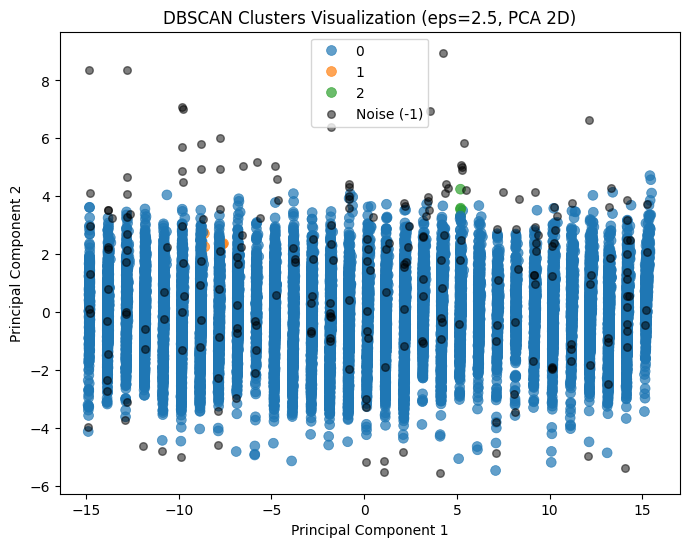

In [75]:
plt.figure(figsize=(8,6))

mask_noise = clusters == -1
mask_clustered = ~mask_noise
# Scatter for clustered points
sns.scatterplot(
    x=X_pca[mask_clustered, 0],
    y=X_pca[mask_clustered, 1],
    hue=clusters[mask_clustered],
    palette="tab10",
    s=50,
    alpha=0.7,
    edgecolor=None
)

# Scatter for noise
plt.scatter(
    X_pca[mask_noise, 0],
    X_pca[mask_noise, 1],
    c="black",
    s=30,
    alpha=0.5,
    label="Noise (-1)"
)

plt.title("DBSCAN Clusters Visualization (eps=2.5, PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
mask_valid = clusters != -1
X_valid = X_pca[mask_valid]
y_valid = clusters[mask_valid]

# --- Evaluation Metrics ---
if len(set(y_valid)) > 1:
    sil_score = silhouette_score(X_valid, y_valid)
    dbi_score = davies_bouldin_score(X_valid, y_valid)
    ch_score = calinski_harabasz_score(X_valid, y_valid)

    print(f"Silhouette Score (excl. noise): {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {dbi_score:.3f} ")
    print(f"Calinski-Harabasz Index: {ch_score:.3f} ")
else:
    print("Metrics cannot be computed (only one cluster after excluding noise).")

Silhouette Score (excl. noise): -0.464
Davies-Bouldin Index: 1.130 
Calinski-Harabasz Index: 3.402 
